In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import random

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 감정 label 리스트
path_all = '/content/drive/MyDrive/AI 감정인식 프로젝트/datasets/'
# path_all 이하에 저장된 모든 폴더경로를 file_paths에 저장
file_paths = glob(f'{path_all}*')

# 빈 리스트 만들기
label_emo = []

#file_paths에 저장된 경로의 제일 마지막에 붙은 감정 이름을 split 해서 label_emo 리스트에 저장
for i in range(len(file_paths)):
  label_emo.append(file_paths[i].split('/')[-1])

label_emo

['angry', 'sad', 'neutral', 'surprise', 'fear', 'happy', 'disgust']

In [ ]:
import glob
list_all = []

# emotion을 0-6까지의 숫자로 저장
# 각 폴더마다 image를 하나씩 가져와서 emotion(숫자)와 함께 빈 리스트에 저장
# 결과물로 나온 'list_all'과 'list_all'을 가공하는 모든 과정은 별도의 참고자료 첨부 예정

for j, emo in enumerate(label_emo): 
  image_files = glob.glob(path_all+emo+'/*')

  for i, image in enumerate(image_files): # 여긴 굳이 enumerate를 할 필요가 없었음,,
    image = cv2.imread(image)

    try:
      image = np.mean(image, axis = 2) # 불러온 각 image를 np.ndarray로 reshape
      image = image.astype('float32')
      image = image / 255
      image = np.reshape(image,(48,48))
        
      list_all.append([image,j]) 
    
    except:
      pass


len(list_all) # 사진 갯수랑 일치하는지 확인

25028

In [ ]:
train_all = []  # 이름을 잘못 설정함,, train_all -> image_all
for i in list_all:
    train_all.append(i[0])


valid_all = [] # 이것도,,, valid_all -> emotion_all
for i in list_all:
    valid_all.append(i[1])

# ppt를 만들때는 변수 이름을 image_all과 emotion_all로 바꾸고 아래에 있는 관련 변수들 전부 바꿔줘야 할 것 같아요!
# 변수 바꿔서 캡쳐해서 ppt만들고 실행은 안해봐도 좋을 것 같아요!!

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train_all, valid_all, test_size = 0.2)


# 적당한 비율(2:8)로 split된것을 확인
print(len(x_train))
print(len(x_valid))

20022
5006


In [ ]:
# model fit하면서 의문의 오류 발생으로 넣어줬던 코드 -> ppt만들때는 이부분에 대한 별도의 설명은 필요 없을듯 합니다.
x_train = np.array(x_train)
x_valid = np.array(x_valid)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

# CNN 적용을 위해서 shape을 다시 변경함
x_train = x_train.reshape((x_train.shape[0], 48, 48, 1))
x_valid = x_valid.reshape((x_valid.shape[0], 48, 48, 1))

# 결과 확인
print(x_train.shape)
print(x_valid.shape)

(20022, 48, 48, 1)
(5006, 48, 48, 1)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 33856)             0         
                                                                 
 dense1 (Dense)              (None, 128)               4333696   
                                                                 
 dense2 (Dense)              (None, 64)                8256      
                                                                 
 dense3 (Dense)              (None, 32)                2080      
                                                      

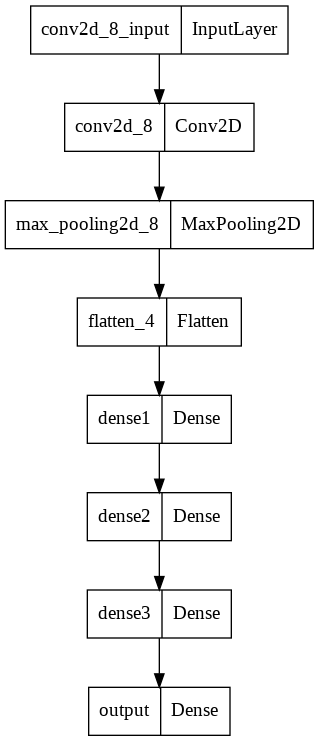

In [ ]:
# module import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping


# model 구성하고 summary, 시각화
# Dense layer는 관련 자료나 예제 참고해서 가장 적합해 보이는 것으로 적용함
# Output layer의 경우에는 여러가지 결과중에 분류하는 케이스라서 activation함수 softmax 사용, 결과 감정이 7가지
model = Sequential([Conv2D(64,(3, 3), activation='relu', input_shape = (48, 48,1)),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(128, activation='relu', name='dense1'),
                    Dense(64, activation='relu', name='dense2'),
                    Dense(32, activation='relu', name='dense3'),
                    Dense(7, activation='softmax', name='output')])

model.summary() 
plot_model(model) # 만들어진 모델 시각화


In [ ]:
# model compile
# One Hot Encoding을 거치지 않은 label을 가졌으므로 sparce_categorical_crossentropy
# optimizer는 sgd or adam 상관 없을 듯
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# epoch을 50으로 많게 설정할 예정이라서 accuracy가 5번 이상 떨어지면 early_stopping 적용되도록 함
early_stopping = EarlyStopping(monitor = 'accuracy', patience = 5)

In [ ]:
# fit
# epoch은 최대한 많이 설정, batch size는 128, 64 다 해봤으나 64에서 accuracy 제일 잘나옴
# ppt에 batch_size 128일때 결과도 첨부하고 싶으면 바꿔서 한번 실행해보셔도 좋을 듯 해용 (시간은 40분정도 걸려요 ㅎㅎ..)

history = model.fit(x_train ,y_train, 
                    epochs = 50, 
                    batch_size=64,
                    callbacks=[early_stopping])

Epoch 1/50
313/313 [==============================] - 42s 132ms/step - loss: 1.8768 - accuracy: 0.2522
Epoch 2/50
313/313 [==============================] - 42s 134ms/step - loss: 1.8406 - accuracy: 0.2644
Epoch 3/50
313/313 [==============================] - 42s 134ms/step - loss: 1.7929 - accuracy: 0.3059
Epoch 4/50
313/313 [==============================] - 42s 135ms/step - loss: 1.7410 - accuracy: 0.3406
Epoch 5/50
313/313 [==============================] - 42s 135ms/step - loss: 1.7005 - accuracy: 0.3603
Epoch 6/50
313/313 [==============================] - 42s 134ms/step - loss: 1.6712 - accuracy: 0.3773
Epoch 7/50
313/313 [==============================] - 42s 134ms/step - loss: 1.6544 - accuracy: 0.3857
Epoch 8/50
313/313 [==============================] - 42s 134ms/step - loss: 1.6327 - accuracy: 0.3991
Epoch 9/50
313/313 [==============================] - 42s 135ms/step - loss: 1.6143 - accuracy: 0.4073
Epoch 10/50
313/313 [==============================] - 42s 135ms/step - l

In [ ]:
# 만든 모델을 가중치만 저장하는 것이 아니라 전체 저장하는 방법 활용함
# 저장한 파일 저한테 있어요
model.save('emotion_model.h5')
# new_model = tf.keras.models.load_model('emotion_model.h5') 로 불러와서 test해볼 수 있음